In [1]:
# Importing libraries

import h5py

import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [2]:
# Open h5py file as readable
file = h5py.File('data/train_images.h5', 'r')

In [3]:
# Listing the keys in order to extract the training images
list(file.keys())

['train_images']

In [4]:
# Checking format to ensure that we have 50k images 128x128
file['train_images']

<HDF5 dataset "train_images": shape (50000, 128, 128, 1), type "|u1">

In [5]:
# Store images in a dataset with each image as a NumPy array
x_train = file['train_images']
dataset = x_train[:]

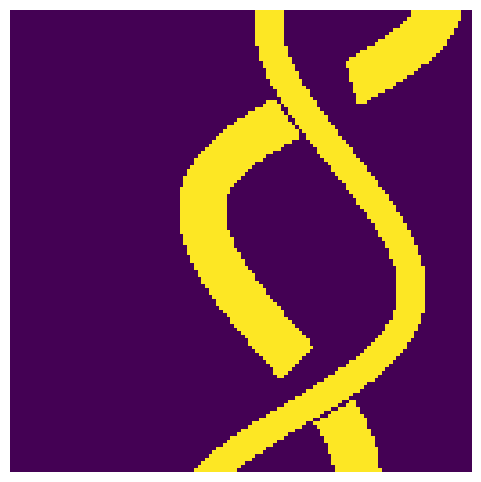

In [6]:
# Plotting images from dataset
plt.figure(figsize=(6,6))

plt.imshow(dataset[15])
plt.axis('off')

plt.show()

# VAE Models

Variational Autoencoders (VAEs) are a type of deep learning model that can be used for image generation. VAEs are an advancement of traditional autoencoders, which map an original image to a latent space using an encoder and then decode it back to the original image using a decoder. VAEs, on the other hand, turn the image into the parameters of a statistical distribution, such as a mean and variance, and then sample from that distribution to generate new images.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow as tf

In [8]:
# Sample vectors from the latenst space
class Sampling(layers.Layer):
    """"Uses (z_mean, z_log_var) to sample z, the vector enconding an image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Reparametrization trick

## Convolutional + Dense VAE

By using both convolutional and dense layers in our network, we can combine spatial awareness with global pattern identification. Additionally, compared to fully connected VAEs, our model has fewer parameters, resulting in computational efficiency. These combined advantages contribute to generating more realistic and semantically appealing images.

However, VAEs often struggle with capturing fine-grained details, and the interpretability of their latent space is not always straightforward. This lack of interpretability makes it challenging to understand and control the generated images. To address the potential issue of overfitting, regularization techniques are introduced in the loss function.

### Network design

In [9]:
# Define the encoder network
latent_dim = 100

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [10]:
# Define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [11]:
# Create the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 65536)        0           ['conv2d_1[0][0]']         

In [12]:
# Create the decoder model
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 1)      289 

### Model 

Regarding the **loss function**: defining the Kullback-Leibler divergence loss, we try to ensure the regularization of the latent space. The KL divergence term encourages the latent space to be close to a normal Gaussian distribution. However it may not be enough to ensure continuity and completeness.

To prevent the VAE from learning to "ignore" the distributions returned, which may have tiny variances or significantly different means, we apply regularization to both the covariance matrix (close to the identity matrix) and the mean matrices (close to zero) of the distribution. This regularization prevents the emergence of punctual distributions and ensures that the distributions are not excessively far from each other.

Finally, we calculate the total loss adding both to the reconstruction loss.

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Kullback-Leibler divergence loss
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss # Mean and covariance regularization
            total_loss = reconstruction_loss + kl_loss + regularization_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }        

In [14]:
# Define the VAE model
vae = VAE(encoder, decoder)

# Compile the VAE model
vae.compile(optimizer=keras.optimizers.Adam())

### Training

In [15]:
# Convert x_train to float32 data type, ensure that the data types of x_train and x_decoded_mean match
x_train = np.expand_dims(x_train, -1).astype("float32") / 255 # Normalization of the pixel values

# Reshape the x_train data to match the input shape (128, 128, 1)
x_train_reshaped = x_train.reshape(-1, 128, 128, 1)

In [196]:
# Train the VAE model
vae.fit(x_train_reshaped, epochs=10, batch_size=32)


Epoch 1/10
1563/1563 [==============================] - 473s 300ms/step - loss: 501.4724 - reconstruction_loss: 167.4030 - kl_loss: 9.5135 - regularization_loss: 0.1903
Epoch 2/10
1563/1563 [==============================] - 460s 294ms/step - loss: 102.5195 - reconstruction_loss: 101.7700 - kl_loss: 0.4166 - regularization_loss: 0.0083
Epoch 3/10
1563/1563 [==============================] - 457s 293ms/step - loss: 101.6707 - reconstruction_loss: 101.1419 - kl_loss: 0.6631 - regularization_loss: 0.0133
Epoch 4/10
1563/1563 [==============================] - 451s 289ms/step - loss: 101.7572 - reconstruction_loss: 101.0710 - kl_loss: 0.6909 - regularization_loss: 0.0138
Epoch 5/10
1563/1563 [==============================] - 454s 291ms/step - loss: 101.7028 - reconstruction_loss: 101.0183 - kl_loss: 0.7178 - regularization_loss: 0.0144
Epoch 6/10
1563/1563 [==============================] - 456s 292ms/step - loss: 101.6192 - reconstruction_loss: 100.6759 - kl_loss: 0.8792 - regularization

### Saving/loading models

When dealing with serializing models in Keras, they can't be serialized and thus saved. Instead we save its weights.

For further details: [François Chollet - Guide to Saving and Serializing Models with Keras in TensorFlow 2.0](https://colab.research.google.com/drive/172D4jishSgE3N7AO6U2OKAA_0wNnrMOq#scrollTo=OOSGiSkHTERy).

In [197]:
# Save the VAE model
vae.save_weights("models/vae_dim100_conv_dense__weights", save_format="tf")

In [75]:
# Uncomment to load a saved VAE model
# new_model = VAE(encoder, decoder)
# new_model.compile(optimizer=keras.optimizers.Adam())

# new_model.fit(x_train_reshaped[:5])
# new_model.load_weights("models/test_saving_vae")

1/1 [==============================] - 1s 1s/step - loss: 11282.7637 - reconstruction_loss: 11282.5391 - kl_loss: 0.1121 - regularization_loss: 0.0022


### Predicting new images

In [198]:
# Generate new images from random latent vectors
num_images = 30  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 364ms/step


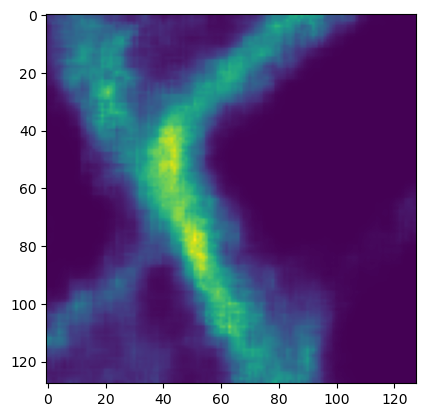

In [199]:
plt.imshow(generated_images[0])

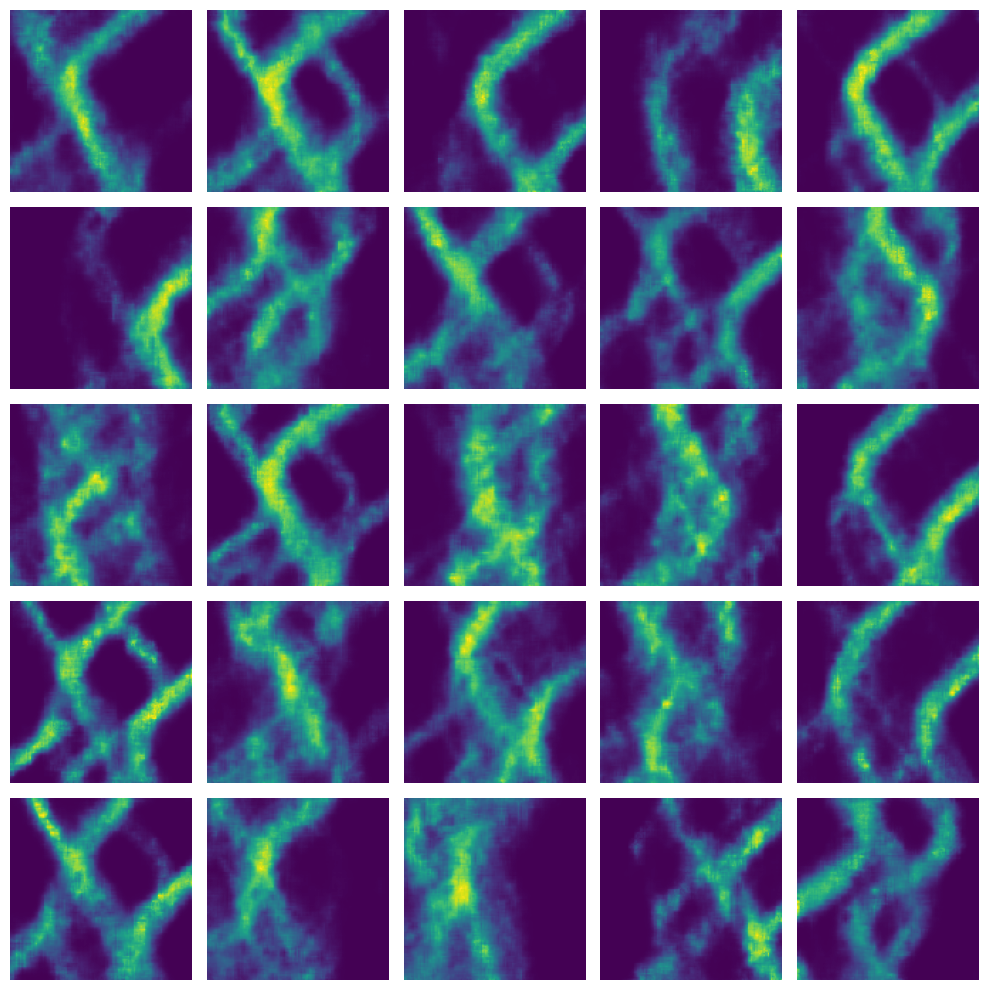

In [218]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

1/1 [==============================] - 0s 26ms/step


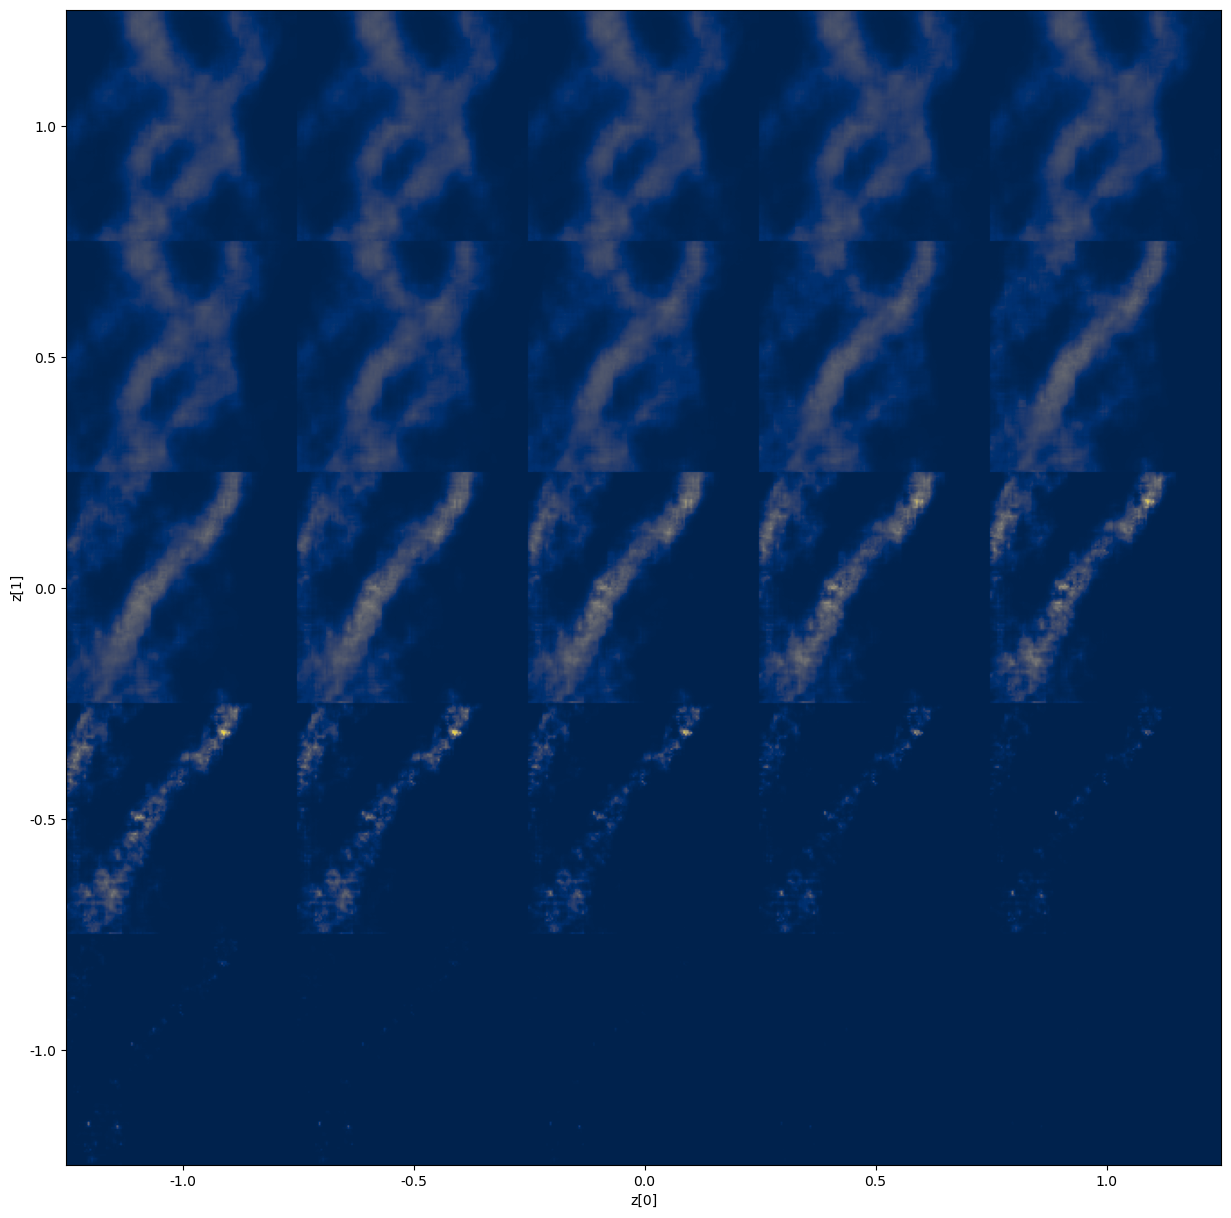

In [217]:
def plot_latent_space(vae, n=5, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # Initial latent vector
    initial_latent_vector = tf.random.normal(shape=(1, latent_dim))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = initial_latent_vector + 0.25 * np.mean(initial_latent_vector)
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            initial_latent_vector = z_sample
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="cividis")
    plt.show()


plot_latent_space(vae)

This plot shows that little changes in the latent space are implying subtle changes in the output generated image, a property we are looking for, regularization of the latent space.

## Fully Convolutional Variational Autoencoders (FCVAEs)

A fully convolutional VAE consists solely of convolutional layers in its design, thereby accurately preserving the spatial properties of the inputs throughout the network. The applications of such networks are often associated with spatially labeling the pixels of an image to understand the relationship between localization and corresponding information. 

However, due to their specialization in operating within local receptive fields, they often lack the ability to capture global patterns, thereby limiting their capacity to generate coherent new images. Additionally, this local property hinders the diversity of the outputs.

### Network design

In [167]:
# Define the encoder network
latent_dim = 10

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(latent_dim, 1, activation="relu")(x)
z_mean = layers.GlobalAveragePooling2D(name="z_mean")(x) # Global average pooling is used to reduce the spatial dimensions of the output.
z_log_var = layers.GlobalAveragePooling2D(name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [168]:

# Define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Reshape((1, 1, latent_dim))(decoder_inputs)
x = layers.Conv2DTranspose(32, 4, strides=1, activation="relu", padding="valid")(x)
x = layers.Conv2DTranspose(16, 4, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, 4, strides=2, activation="relu", padding="same")(x) 
x = layers.Conv2DTranspose(4, 4, strides=2, activation="relu", padding="same")(x) 
x = layers.Conv2DTranspose(2, 4, strides=2, activation="relu", padding="same")(x) 
decoder_outputs = layers.Conv2DTranspose(1, 4, strides=2, activation="sigmoid", padding="same")(x)


In [169]:
# Create the encoder model
encoder_convolutional = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_convolutional.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 64, 64, 32)   320         ['input_41[0][0]']               
                                                                                                  
 conv2d_55 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_54[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_55[0][0]']        

In [170]:
# Create the decoder model
decoder_convolutional = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_convolutional.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 10)]              0         
                                                                 
 reshape_25 (Reshape)        (None, 1, 1, 10)          0         
                                                                 
 conv2d_transpose_143 (Conv2  (None, 4, 4, 32)         5152      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_144 (Conv2  (None, 8, 8, 16)         8208      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_145 (Conv2  (None, 16, 16, 8)        2056      
 DTranspose)                                                     
                                                           

### Model

In [171]:
class VAEConvolutional(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss
            # total_loss = reconstruction_loss + kl_loss + regularization_loss # The composed loss function rapidly makes the model generate 0's images.
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }        

In [172]:
# Define the VAE model
vae_convolutional = VAE(encoder_convolutional, decoder_convolutional)

# Compile the VAE model
vae_convolutional.compile(optimizer=keras.optimizers.Adam())

### Training

In [173]:
# Train the VAE model
vae_convolutional.fit(x_train_reshaped, epochs=5, batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 437s 279ms/step - loss: 1646.0846 - reconstruction_loss: 471.8866 - kl_loss: 6.3785 - regularization_loss: 1.2757
Epoch 2/5
1563/1563 [==============================] - 420s 268ms/step - loss: 106.6930 - reconstruction_loss: 105.6445 - kl_loss: 0.0165 - regularization_loss: 0.0033
Epoch 3/5
1563/1563 [==============================] - 418s 267ms/step - loss: 103.7978 - reconstruction_loss: 103.5669 - kl_loss: 3.4666e-04 - regularization_loss: 6.9332e-05
Epoch 4/5
1563/1563 [==============================] - 419s 268ms/step - loss: 103.0543 - reconstruction_loss: 103.0394 - kl_loss: 2.3256e-08 - regularization_loss: 4.6948e-09
Epoch 5/5
1563/1563 [==============================] - 424s 271ms/step - loss: 102.7910 - reconstruction_loss: 102.8064 - kl_loss: 0.0000e+00 - regularization_loss: 1.7631e-17


### Saving/loading models

In [174]:
# Save the VAE model
vae_convolutional.save_weights("models/vae_convolutional_dim10__weights", save_format="tf")

In [175]:
# Uncomment to load a saved VAE model
# new_model = VAE(encoder, decoder)
# new_model.compile(optimizer=keras.optimizers.Adam())

# new_model.fit(x_train_reshaped[:5])
# new_model.load_weights("models/test_saving_vae")

### Predicting new images

In [176]:
# Generate new images from random latent vectors
num_images = 10  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae_convolutional.decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 210ms/step


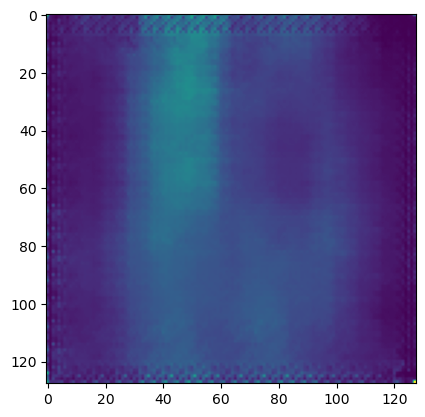

In [177]:
plt.imshow(generated_images[0])

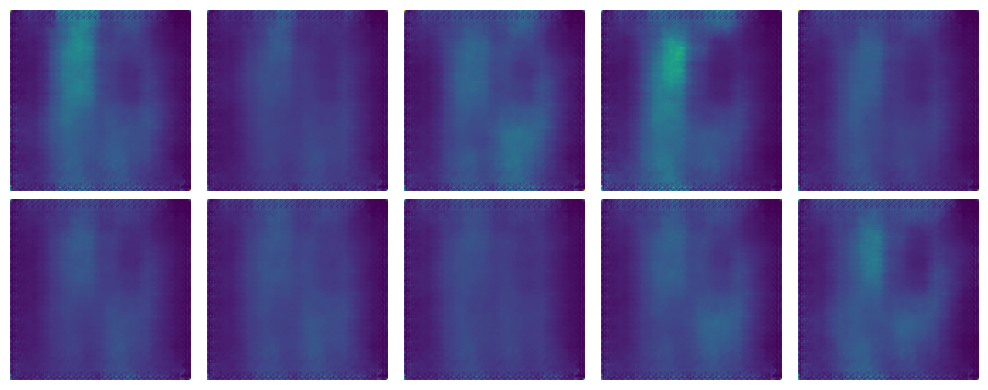

In [178]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Fully Connected Variational Autoencoders (FCVAEs)

A fully connected VAE, on the other hand, consists solely of dense layers, where all neurons are connected between layers, forming a dense network. Such networks are often used in classification problems, given their capacity to capture global information and patterns from the input.

However, there are several downsides to fully connected VAEs. Since they flatten the inputs, they have limited spatial awareness, resulting in generated images that lack specific spatial patterns and fine details. Additionally, the high number of parameters in these networks makes the models computationally expensive and memory-intensive. 

### Network Design

In [17]:
# Encoder
latent_dim = 5

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [18]:
# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128 * 128, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((128, 128, 1))(x)

In [19]:
# Create the encoder model
encoder_connected = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_connected.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 flatten_1 (Flatten)            (None, 16384)        0           ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 256)          4194560     ['flatten_1[0][0]']              
                                                                                                  
 dense_3 (Dense)                (None, 128)          32896       ['dense_2[0][0]']          

In [20]:
# Create the decoder model
decoder_connected = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_connected.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 128)               768       
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 16384)             4210688   
                                                                 
 reshape_1 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
Total params: 4,244,480
Trainable params: 4,244,480
Non-trainable params: 0
_________________________________________________________________


### Model

In [16]:
class VAEConnected(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss
            # total_loss = reconstruction_loss + kl_loss + regularization_loss
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }        

In [69]:
# Define the VAE model
vae_connected = VAEConnected(encoder_connected, decoder_connected)

# Compile the VAE model
vae_connected.compile(optimizer=keras.optimizers.Adam())

### Training

In [70]:
# Train the VAE model
vae_connected.fit(x_train_reshaped, epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 68s 42ms/step - loss: 633.7559 - reconstruction_loss: 117.5909 - kl_loss: 11.1099 - regularization_loss: 4.4440
Epoch 2/10
1563/1563 [==============================] - 63s 40ms/step - loss: 0.7721 - reconstruction_loss: 0.7712 - kl_loss: 17.6995 - regularization_loss: 7.0798
Epoch 3/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.7697 - reconstruction_loss: 0.7697 - kl_loss: 19.1669 - regularization_loss: 7.6668
Epoch 4/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.7695 - reconstruction_loss: 0.7689 - kl_loss: 17.1324 - regularization_loss: 6.8530
Epoch 5/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.7698 - reconstruction_loss: 0.7646 - kl_loss: 12.8675 - regularization_loss: 5.1470
Epoch 6/10
1563/1563 [==============================] - 66s 42ms/step - loss: 0.6971 - reconstruction_loss: 0.6826 - kl_loss: 12.7810 - regularization_loss: 5.1124
Epoch 7/10
1

### Saving/loading models


In [71]:
# Save the VAE model
vae_connected.save_weights("models/vae_connected_dim100__weights", save_format="tf")

In [21]:
# Uncomment to load a saved fully connected VAE model
vae_connected = VAEConnected(encoder_connected, decoder_connected)
vae_connected.compile(optimizer=keras.optimizers.Adam())

vae_connected.fit(x_train_reshaped[:5])
vae_connected.load_weights("models/vae_connected_dim100__weights")

1/1 [==============================] - 2s 2s/step - loss: 11356.0938 - reconstruction_loss: 11356.0938 - kl_loss: 1.0699e-05 - regularization_loss: 4.2657e-06


### Predicting new images

In [23]:
# Generate new images from random latent vectors
num_images = 10  # Number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae_connected.decoder.predict(random_latent_vectors)

1/1 [==============================] - 0s 126ms/step


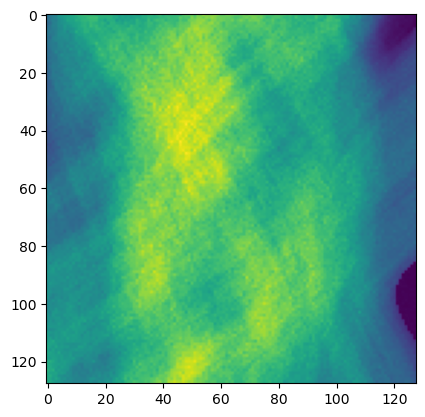

In [25]:
plt.imshow(generated_images[0])

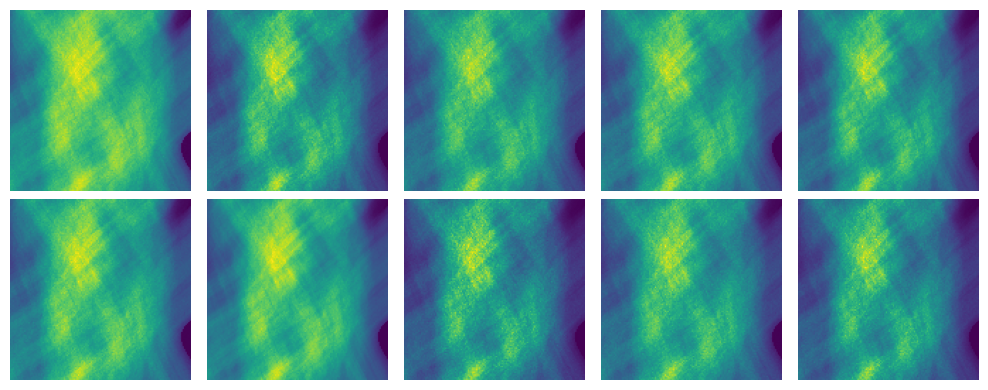

In [26]:
import matplotlib.pyplot as plt

# Reshape the generated images to (num_images, 128, 128)
generated_images = generated_images.reshape((num_images, 128, 128))

# Create a figure and axes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the axes and images
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(generated_images[i], cmap='viridis')
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

1/1 [==============================] - 0s 28ms/step


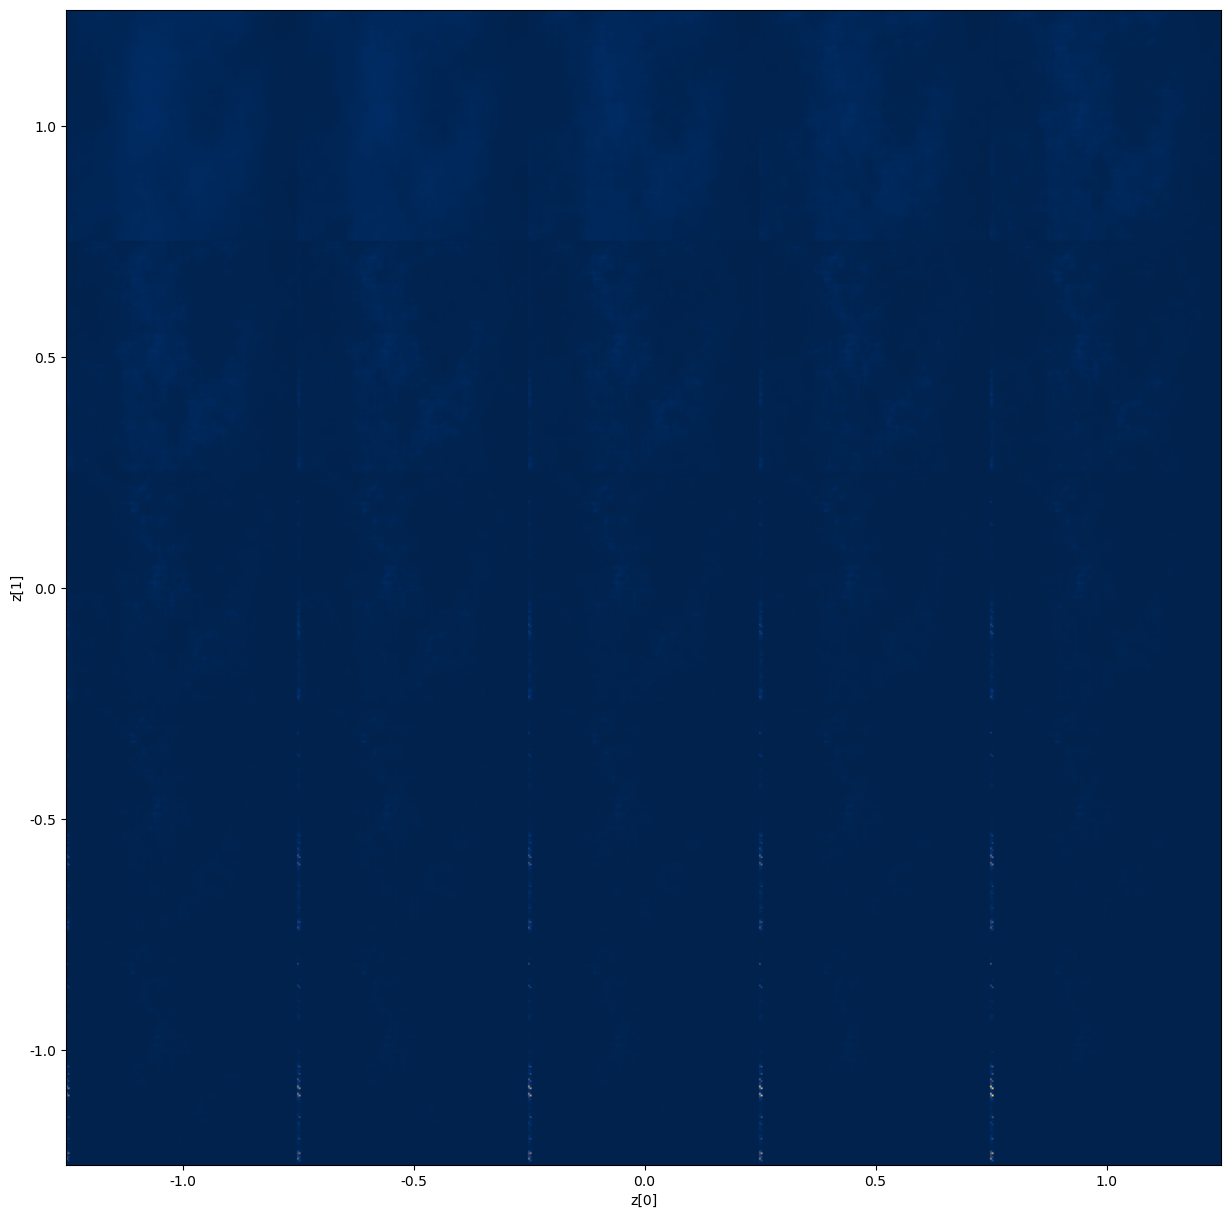

In [ ]:
def plot_latent_space(vae, n=5, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    # Initial latent vector
    initial_latent_vector = tf.random.normal(shape=(1, latent_dim))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = initial_latent_vector + 0.5
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            initial_latent_vector = z_sample
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="cividis")
    plt.show()


plot_latent_space(vae)

In [ ]:
file.close()

# References